In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def load_data(filepath):
    """Loads data from a TSV file."""
    try:
        df = pd.read_csv(filepath, sep='\t', header=None, on_bad_lines='skip', names=['native', 'roman', 'count'])
        df.dropna(subset=['native', 'roman'], inplace=True)
        input_texts = df['roman'].astype(str).tolist()
        target_texts = df['native'].astype(str).tolist()
        return input_texts, target_texts
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return [], []

# --- Define file paths ---
dataset_base_dir = 'dakshina_dataset_v1.0' 
language = 'hi' # Hindi

train_file = os.path.join(dataset_base_dir, language, 'lexicons', f'{language}.translit.sampled.train.tsv')
dev_file = os.path.join(dataset_base_dir, language, 'lexicons', f'{language}.translit.sampled.dev.tsv')
test_file = os.path.join(dataset_base_dir, language, 'lexicons', f'{language}.translit.sampled.test.tsv')

# Load all data splits
input_texts_train_full, target_texts_train_full = load_data(train_file)
input_texts_val, target_texts_val = load_data(dev_file)
input_texts_test, target_texts_test = load_data(test_file)

print(f"Total training samples: {len(input_texts_train_full)}")
print(f"Total validation samples: {len(input_texts_val)}")
print(f"Total test samples: {len(input_texts_test)}")

# --- Character sets, tokenization, and max_lengths ---
# Build vocabulary from all available text data to ensure consistency
all_input_texts_for_vocab = input_texts_train_full + input_texts_val + input_texts_test
all_target_texts_for_vocab = target_texts_train_full + target_texts_val + target_texts_test

input_characters = set()
target_characters = set()

for text in all_input_texts_for_vocab:
    for char in str(text):
        if char not in input_characters:
            input_characters.add(char)

for text in all_target_texts_for_vocab:
    for char in str(text):
        if char not in target_characters:
            target_characters.add(char)

SOS_TOKEN = '\t' # Start Of Sequence
EOS_TOKEN = '\n' # End Of Sequence
target_characters.add(SOS_TOKEN)
target_characters.add(EOS_TOKEN)

input_char_list = sorted(list(input_characters))
target_char_list = sorted(list(target_characters))

num_encoder_tokens = len(input_char_list)
num_decoder_tokens = len(target_char_list)

input_token_index = {char: i for i, char in enumerate(input_char_list)}
target_token_index = {char: i for i, char in enumerate(target_char_list)}

reverse_input_char_index = {i: char for char, i in input_token_index.items()}
reverse_target_char_index = {i: char for char, i in target_token_index.items()}

max_encoder_seq_length = max(len(str(text)) for text in all_input_texts_for_vocab)
max_decoder_seq_length = max(len(str(text)) for text in all_target_texts_for_vocab) + 2 # +2 for SOS & EOS

print(f"\nNumber of unique input tokens: {num_encoder_tokens}")
print(f"Number of unique output tokens: {num_decoder_tokens}")
print(f"Max sequence length for inputs: {max_encoder_seq_length}")
print(f"Max sequence length for outputs: {max_decoder_seq_length}")

# --- Vectorize data function ---
def vectorize_data(input_texts, target_texts):
    encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype="float32")
    decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length), dtype="float32")
    # For training, target data needs to be one-hot encoded for categorical_crossentropy
    decoder_target_data_one_hot = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(str(input_text)):
            if t < max_encoder_seq_length and char in input_token_index:
                 encoder_input_data[i, t] = input_token_index[char]
        
        processed_target_text = SOS_TOKEN + str(target_text) + EOS_TOKEN
        for t, char in enumerate(processed_target_text):
            if t < max_decoder_seq_length and char in target_token_index:
                decoder_input_data[i, t] = target_token_index[char]
                if t > 0: 
                    decoder_target_data_one_hot[i, t - 1, target_token_index[char]] = 1.0
    
    return encoder_input_data, decoder_input_data, decoder_target_data_one_hot

# Vectorize training and validation data (needed for retraining the model)
encoder_input_train_full_vec, decoder_input_train_full_vec, decoder_target_train_full_vec = vectorize_data(
    input_texts_train_full, target_texts_train_full
)
encoder_input_val_vec, decoder_input_val_vec, decoder_target_val_vec = vectorize_data(
    input_texts_val, target_texts_val
)
print("\nData vectorization complete for train and val sets.")

Total training samples: 44202
Total validation samples: 4358
Total test samples: 4502

Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 21

Data vectorization complete for train and val sets.


In [4]:
class ModelConfig:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

best_vanilla_config_dict = {
    "batch_size": 356,
    "beam_size": 5,
    "cell_type": "GRU",
    "decoder_layers": 2,
    "dropout_rate": 0.2,
    "early_stopping_patience": 5,
    "encoder_layers": 1,
    "epochs": 50, 
    "hidden_size": 256,
    "input_embedding_size": 64,
    "learning_rate": 0.001,
    "optimizer": "nadam"
}
best_vanilla_config = ModelConfig(best_vanilla_config_dict)
print("Using Best Vanilla Seq2Seq Configuration:", best_vanilla_config_dict)

# --- Vanilla Seq2Seq Model Building Function (from Q1-Q4 notebook) ---
def build_seq2seq_model(config): # Expects config to be an object with attributes
    encoder_inputs = Input(shape=(None,), name="encoder_inputs") 
    emb_enc = Embedding(num_encoder_tokens, config.input_embedding_size, name="encoder_embedding")(encoder_inputs)
    
    current_encoder_output = emb_enc
    encoder_states_list = [] 

    # Select RNN cell type
    if config.cell_type == "LSTM":
        RNNCell = LSTM
    elif config.cell_type == "GRU":
        RNNCell = GRU
    else: 
        RNNCell = keras.layers.SimpleRNN

    for i in range(config.encoder_layers):
        is_last_layer = (i == config.encoder_layers - 1)
        
        rnn_layer = RNNCell(config.hidden_size, 
                            return_sequences=True if is_last_layer else (config.encoder_layers > 1), # Only last layer needs to output full sequence for viz. If multiple layers, intermediate ones also need sequences.
                            return_state=True, 
                            dropout=config.dropout_rate, 
                            name=f"encoder_{config.cell_type}_{i}")
        
        if config.cell_type == "LSTM":
            encoder_rnn_output_seq, state_h, state_c = rnn_layer(current_encoder_output)
            layer_states = [state_h, state_c]
        else: 
            encoder_rnn_output_seq, state_h = rnn_layer(current_encoder_output)
            layer_states = [state_h]
        
        if is_last_layer: 
            encoder_states_list = layer_states # Final hidden state for decoder init
        current_encoder_output = encoder_rnn_output_seq


    decoder_inputs = Input(shape=(None,), name="decoder_inputs")
    emb_dec = Embedding(num_decoder_tokens, config.input_embedding_size, name="decoder_embedding")(decoder_inputs)
    current_decoder_output = emb_dec
    
    temp_decoder_states_input = encoder_states_list # Use final encoder states for first decoder layer

    for i in range(config.decoder_layers):
        rnn_layer_dec = RNNCell(config.hidden_size, 
                                return_sequences=True, 
                                return_state=True,    
                                dropout=config.dropout_rate,
                                name=f"decoder_{config.cell_type}_{i}")
        
        initial_states_for_layer = temp_decoder_states_input if i == 0 else None # Keras handles subsequent layer states
        
        if config.cell_type == "LSTM":
            current_decoder_output, dec_state_h, dec_state_c = rnn_layer_dec(current_decoder_output, initial_state=initial_states_for_layer)
        else: 
            current_decoder_output, dec_state_h = rnn_layer_dec(current_decoder_output, initial_state=initial_states_for_layer)
            
    decoder_dense = Dense(num_decoder_tokens, activation="softmax", name="decoder_output_dense")
    decoder_outputs_final = decoder_dense(current_decoder_output)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)

    if config.optimizer == 'adam':
        optimizer_choice = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    elif config.optimizer == 'rmsprop':
        optimizer_choice = tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate)
    elif config.optimizer == 'nadam':
        optimizer_choice = tf.keras.optimizers.Nadam(learning_rate=config.learning_rate)
    else:
        optimizer_choice = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
            
    model.compile(optimizer=optimizer_choice, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

print("\n--- Retraining best vanilla model on full training data ---")
keras.backend.clear_session()
trained_vanilla_model = build_seq2seq_model(best_vanilla_config)

early_stopping_vanilla_retrain = EarlyStopping(
    monitor='val_loss', 
    patience=best_vanilla_config.early_stopping_patience, 
    restore_best_weights=True,
    verbose=1
)

history_vanilla_retrain = trained_vanilla_model.fit(
    [encoder_input_train_full_vec, decoder_input_train_full_vec],
    decoder_target_train_full_vec,
    batch_size=best_vanilla_config.batch_size,
    epochs=best_vanilla_config.epochs, # Use epochs from best config
    validation_data=([encoder_input_val_vec, decoder_input_val_vec], decoder_target_val_vec),
    callbacks=[early_stopping_vanilla_retrain],
    verbose=1
)
print("Vanilla model retraining complete.")

Using Best Vanilla Seq2Seq Configuration: {'batch_size': 356, 'beam_size': 5, 'cell_type': 'GRU', 'decoder_layers': 2, 'dropout_rate': 0.2, 'early_stopping_patience': 5, 'encoder_layers': 1, 'epochs': 50, 'hidden_size': 256, 'input_embedding_size': 64, 'learning_rate': 0.001, 'optimizer': 'nadam'}

--- Retraining best vanilla model on full training data ---
Epoch 1/50
125/125 [==============================] - 11s 41ms/step - loss: 1.2031 - accuracy: 0.0646 - val_loss: 1.1579 - val_accuracy: 0.0603
Epoch 2/50
125/125 [==============================] - 4s 29ms/step - loss: 1.1850 - accuracy: 0.0668 - val_loss: 1.1297 - val_accuracy: 0.0671
Epoch 3/50
125/125 [==============================] - 4s 30ms/step - loss: 1.1751 - accuracy: 0.0685 - val_loss: 1.1325 - val_accuracy: 0.0649
Epoch 4/50
125/125 [==============================] - 4s 30ms/step - loss: 1.1116 - accuracy: 0.0742 - val_loss: 1.0215 - val_accuracy: 0.0749
Epoch 5/50
125/125 [==============================] - 4s 30ms/step 

In [5]:
def build_visualization_inference_models(training_model, config):
    # --- Encoder Model for Visualization ---
    # This model will output all hidden states from the last encoder layer.
    encoder_inputs_viz = training_model.get_layer("encoder_inputs").input
    
    # Trace outputs through encoder layers
    current_enc_output_viz = training_model.get_layer("encoder_embedding")(encoder_inputs_viz)
    encoder_all_hidden_states_output = None # Will hold seq from last layer
    final_encoder_states_output = None    # Will hold final state from last layer

    for i in range(config.encoder_layers):
        encoder_rnn_layer_viz = training_model.get_layer(f"encoder_{config.cell_type}_{i}")
        
        if config.cell_type == "LSTM":
            # Get all hidden states from this layer and the final h and c states
            current_enc_output_viz, state_h_enc, state_c_enc = encoder_rnn_layer_viz(current_enc_output_viz)
            if i == config.encoder_layers - 1: # Last layer
                encoder_all_hidden_states_output = current_enc_output_viz
                final_encoder_states_output = [state_h_enc, state_c_enc]
        else: # GRU or SimpleRNN
            current_enc_output_viz, state_h_enc = encoder_rnn_layer_viz(current_enc_output_viz)
            if i == config.encoder_layers - 1: # Last layer
                encoder_all_hidden_states_output = current_enc_output_viz
                final_encoder_states_output = [state_h_enc]
                
    encoder_model_viz = Model(encoder_inputs_viz, [encoder_all_hidden_states_output] + final_encoder_states_output)
  
    decoder_hidden_size_viz = config.hidden_size
    
    decoder_input_single_step_viz = Input(shape=(1,), name="decoder_input_single_step_viz")
    
    # Initial states for the decoder (list of tensors, one for h, one for c if LSTM, for EACH layer)
    decoder_initial_states_inputs_viz_list = []
    for i in range(config.decoder_layers):
        state_h_name = f"decoder_state_h_input_layer{i}_viz"
        decoder_state_input_h = Input(shape=(decoder_hidden_size_viz,), name=state_h_name)
        decoder_initial_states_inputs_viz_list.append(decoder_state_input_h)
        if config.cell_type == "LSTM":
            state_c_name = f"decoder_state_c_input_layer{i}_viz"
            decoder_state_input_c = Input(shape=(decoder_hidden_size_viz,), name=state_c_name)
            decoder_initial_states_inputs_viz_list.append(decoder_state_input_c)

    # Get layers from the trained model
    dec_emb_layer_viz = training_model.get_layer("decoder_embedding")
    decoder_dense_viz = training_model.get_layer("decoder_output_dense")

    # Decoder step execution
    current_dec_emb_viz = dec_emb_layer_viz(decoder_input_single_step_viz) # Shape (batch, 1, embedding_dim)
    
    current_dec_input_for_rnn = current_dec_emb_viz
    new_decoder_states_output_list_viz = [] # To store output states from ALL layers
    last_layer_hidden_state_sequence = None # Hidden state from the final decoder layer output

    state_idx_offset = 0
    for i in range(config.decoder_layers):
        decoder_rnn_layer_viz = training_model.get_layer(f"decoder_{config.cell_type}_{i}")
        
        # Prepare initial_state for this specific layer from the input states list
        if config.cell_type == "LSTM":
            layer_initial_states_viz = [decoder_initial_states_inputs_viz_list[state_idx_offset], 
                                        decoder_initial_states_inputs_viz_list[state_idx_offset+1]]
            state_idx_offset += 2
            rnn_output_sequence, state_h_dec, state_c_dec = decoder_rnn_layer_viz(
                current_dec_input_for_rnn, initial_state=layer_initial_states_viz
            )
            new_decoder_states_output_list_viz.extend([state_h_dec, state_c_dec])
        else: # GRU or SimpleRNN
            layer_initial_states_viz = [decoder_initial_states_inputs_viz_list[state_idx_offset]]
            state_idx_offset += 1
            rnn_output_sequence, state_h_dec = decoder_rnn_layer_viz(
                current_dec_input_for_rnn, initial_state=layer_initial_states_viz
            )
            new_decoder_states_output_list_viz.append(state_h_dec)
        
        current_dec_input_for_rnn = rnn_output_sequence # Output sequence of this layer is input to next
        if i == config.decoder_layers - 1: # If this is the last decoder layer
            last_layer_hidden_state_sequence = rnn_output_sequence # This is h_t for the last layer

    # Final dense layer for this step, uses output from last RNN layer
    decoder_output_final_step_viz = decoder_dense_viz(last_layer_hidden_state_sequence) # Shape (batch, 1, num_decoder_tokens)
    squeezed_decoder_output_viz = tf.squeeze(decoder_output_final_step_viz, axis=1) # (batch, num_decoder_tokens)

    last_layer_final_h_state_output = new_decoder_states_output_list_viz[-2] if config.cell_type == "LSTM" else new_decoder_states_output_list_viz[-1]


    decoder_model_viz = Model(
        [decoder_input_single_step_viz] + decoder_initial_states_inputs_viz_list, 
        [squeezed_decoder_output_viz, last_layer_final_h_state_output] + new_decoder_states_output_list_viz
    )
    
    return encoder_model_viz, decoder_model_viz

# Build the visualization inference models
encoder_model_viz, decoder_model_viz = build_visualization_inference_models(trained_vanilla_model, best_vanilla_config)
print("\nVisualization inference models built.")
if encoder_model_viz: encoder_model_viz.summary(line_length=120)
if decoder_model_viz: decoder_model_viz.summary(line_length=120)



Visualization inference models built.
Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 encoder_inputs (InputLayer)                          [(None, None)]                                  0                 
                                                                                                                        
 encoder_embedding (Embedding)                        (None, None, 64)                                1664              
                                                                                                                        
 encoder_GRU_0 (GRU)                                  [(None, None, 256),                             247296            
                                                       (None, 256)]                              

In [6]:
# Cell 5: Decoding Function to Collect States and Compute Pseudo-Attention

def decode_and_compute_pseudo_attention(input_seq_vectorized, encoder_model, decoder_model, config):
    # Encode the input
    encoder_outputs_viz = encoder_model.predict(input_seq_vectorized, verbose=0)
    all_encoder_h_states = encoder_outputs_viz[0] # Shape: (1, input_seq_len, encoder_hidden_dim)
    
    current_decoder_states_for_step = []
    # States from last encoder layer for the first decoder layer
    num_enc_states_to_pass = 2 if config.cell_type == "LSTM" else 1
    current_decoder_states_for_step.extend(encoder_outputs_viz[1:1+num_enc_states_to_pass])
    
    # Zero states for subsequent decoder layers (if any) for the first step
    num_state_elements_per_layer = 2 if config.cell_type == "LSTM" else 1
    for _ in range(1, config.decoder_layers): # For 2nd decoder layer onwards
        for _ in range(num_state_elements_per_layer):
            current_decoder_states_for_step.append(np.zeros((1, config.hidden_size)))


    # Start decoding with SOS token
    last_token_idx = target_token_index[SOS_TOKEN]
    
    decoded_token_indices = []
    collected_decoder_h_states = [] # To store h_state from the last decoder layer at each step
    
    for _ in range(max_decoder_seq_length): # Max output length
        decoder_input_for_step = np.array([[last_token_idx]])
        
        decoder_model_inputs_viz = [decoder_input_for_step] + current_decoder_states_for_step
        
        # Predict
        decoder_pred_outputs_viz = decoder_model.predict(decoder_model_inputs_viz, verbose=0)
        
        output_token_probs = decoder_pred_outputs_viz[0]    # Probabilities
        last_layer_h_dec = decoder_pred_outputs_viz[1]      # h_state from last decoder layer
        new_decoder_all_layer_states = decoder_pred_outputs_viz[2:] # All states for next step

        # Choose token with highest probability (greedy)
        sampled_token_idx = np.argmax(output_token_probs[0, :])
        
        if sampled_token_idx == target_token_index[EOS_TOKEN]:
            break 
        
        decoded_token_indices.append(sampled_token_idx)
        collected_decoder_h_states.append(last_layer_h_dec[0]) # Shape (hidden_dim,)
        
        # Update for next step
        last_token_idx = sampled_token_idx
        current_decoder_states_for_step = new_decoder_all_layer_states
    
    final_all_encoder_h = np.squeeze(all_encoder_h_states, axis=0)
    final_collected_decoder_h = np.array(collected_decoder_h_states) if collected_decoder_h_states else np.array([])

    # Compute pseudo-attention scores (dot product similarity)
    # pseudo_attention_matrix[i, j] = dot(decoder_h_i, encoder_h_j)
    if final_collected_decoder_h.size > 0 and final_all_encoder_h.size > 0 :
        # Ensure decoder states are 2D (output_len, hidden_dim) even if output_len is 1
        if final_collected_decoder_h.ndim == 1:
            final_collected_decoder_h = np.expand_dims(final_collected_decoder_h, axis=0)

        similarity_matrix = np.dot(final_collected_decoder_h, final_all_encoder_h.T) # (output_len, input_len)
        
        if similarity_matrix.size > 0:
            pseudo_attention_matrix = tf.nn.softmax(similarity_matrix, axis=-1).numpy()
        else:
            pseudo_attention_matrix = np.array([])
    else:
        pseudo_attention_matrix = np.array([])
        
    # Convert decoded indices to string
    decoded_sentence = "".join([reverse_target_char_index.get(idx, '') for idx in decoded_token_indices])
        
    return decoded_sentence, pseudo_attention_matrix, final_all_encoder_h, final_collected_decoder_h

print("Decoding function for pseudo-attention defined.")

Decoding function for pseudo-attention defined.



Processing sample 1/9: 'jeevraaj'
  Input: jeevraaj
  Predicted Output: जीवराज
  Pseudo-Attention Matrix Shape: (6, 20)

Processing sample 2/9: 'dhkelate'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: dhkelate
  Predicted Output: ध्रेलेत्य
  Pseudo-Attention Matrix Shape: (9, 20)

Processing sample 3/9: 'aabru'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: aabru
  Predicted Output: आब्रू
  Pseudo-Attention Matrix Shape: (5, 20)

Processing sample 4/9: 'ghumaan'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: ghumaan
  Predicted Output: घुमान
  Pseudo-Attention Matrix Shape: (5, 20)

Processing sample 5/9: 'agavai'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: agavai
  Predicted Output: अगवाई
  Pseudo-Attention Matrix Shape: (5, 20)

Processing sample 6/9: 'feka'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: feka
  Predicted Output: फेक
  Pseudo-Attention Matrix Shape: (3, 20)

Processing sample 7/9: 'rajinaama'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: rajinaama
  Predicted Output: राजिनाम
  Pseudo-Attention Matrix Shape: (7, 20)

Processing sample 8/9: 'hippopotamus'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: hippopotamus
  Predicted Output: हिप्पूपोस्किप
  Pseudo-Attention Matrix Shape: (13, 20)

Processing sample 9/9: 'pidiya'


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)


  Input: pidiya
  Predicted Output: पीडिया
  Pseudo-Attention Matrix Shape: (6, 20)


C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:109: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
C:\Users\prana\AppData\Local\Temp\ipykernel_37992\873457550.py:109: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
C:\Users\prana\AppD

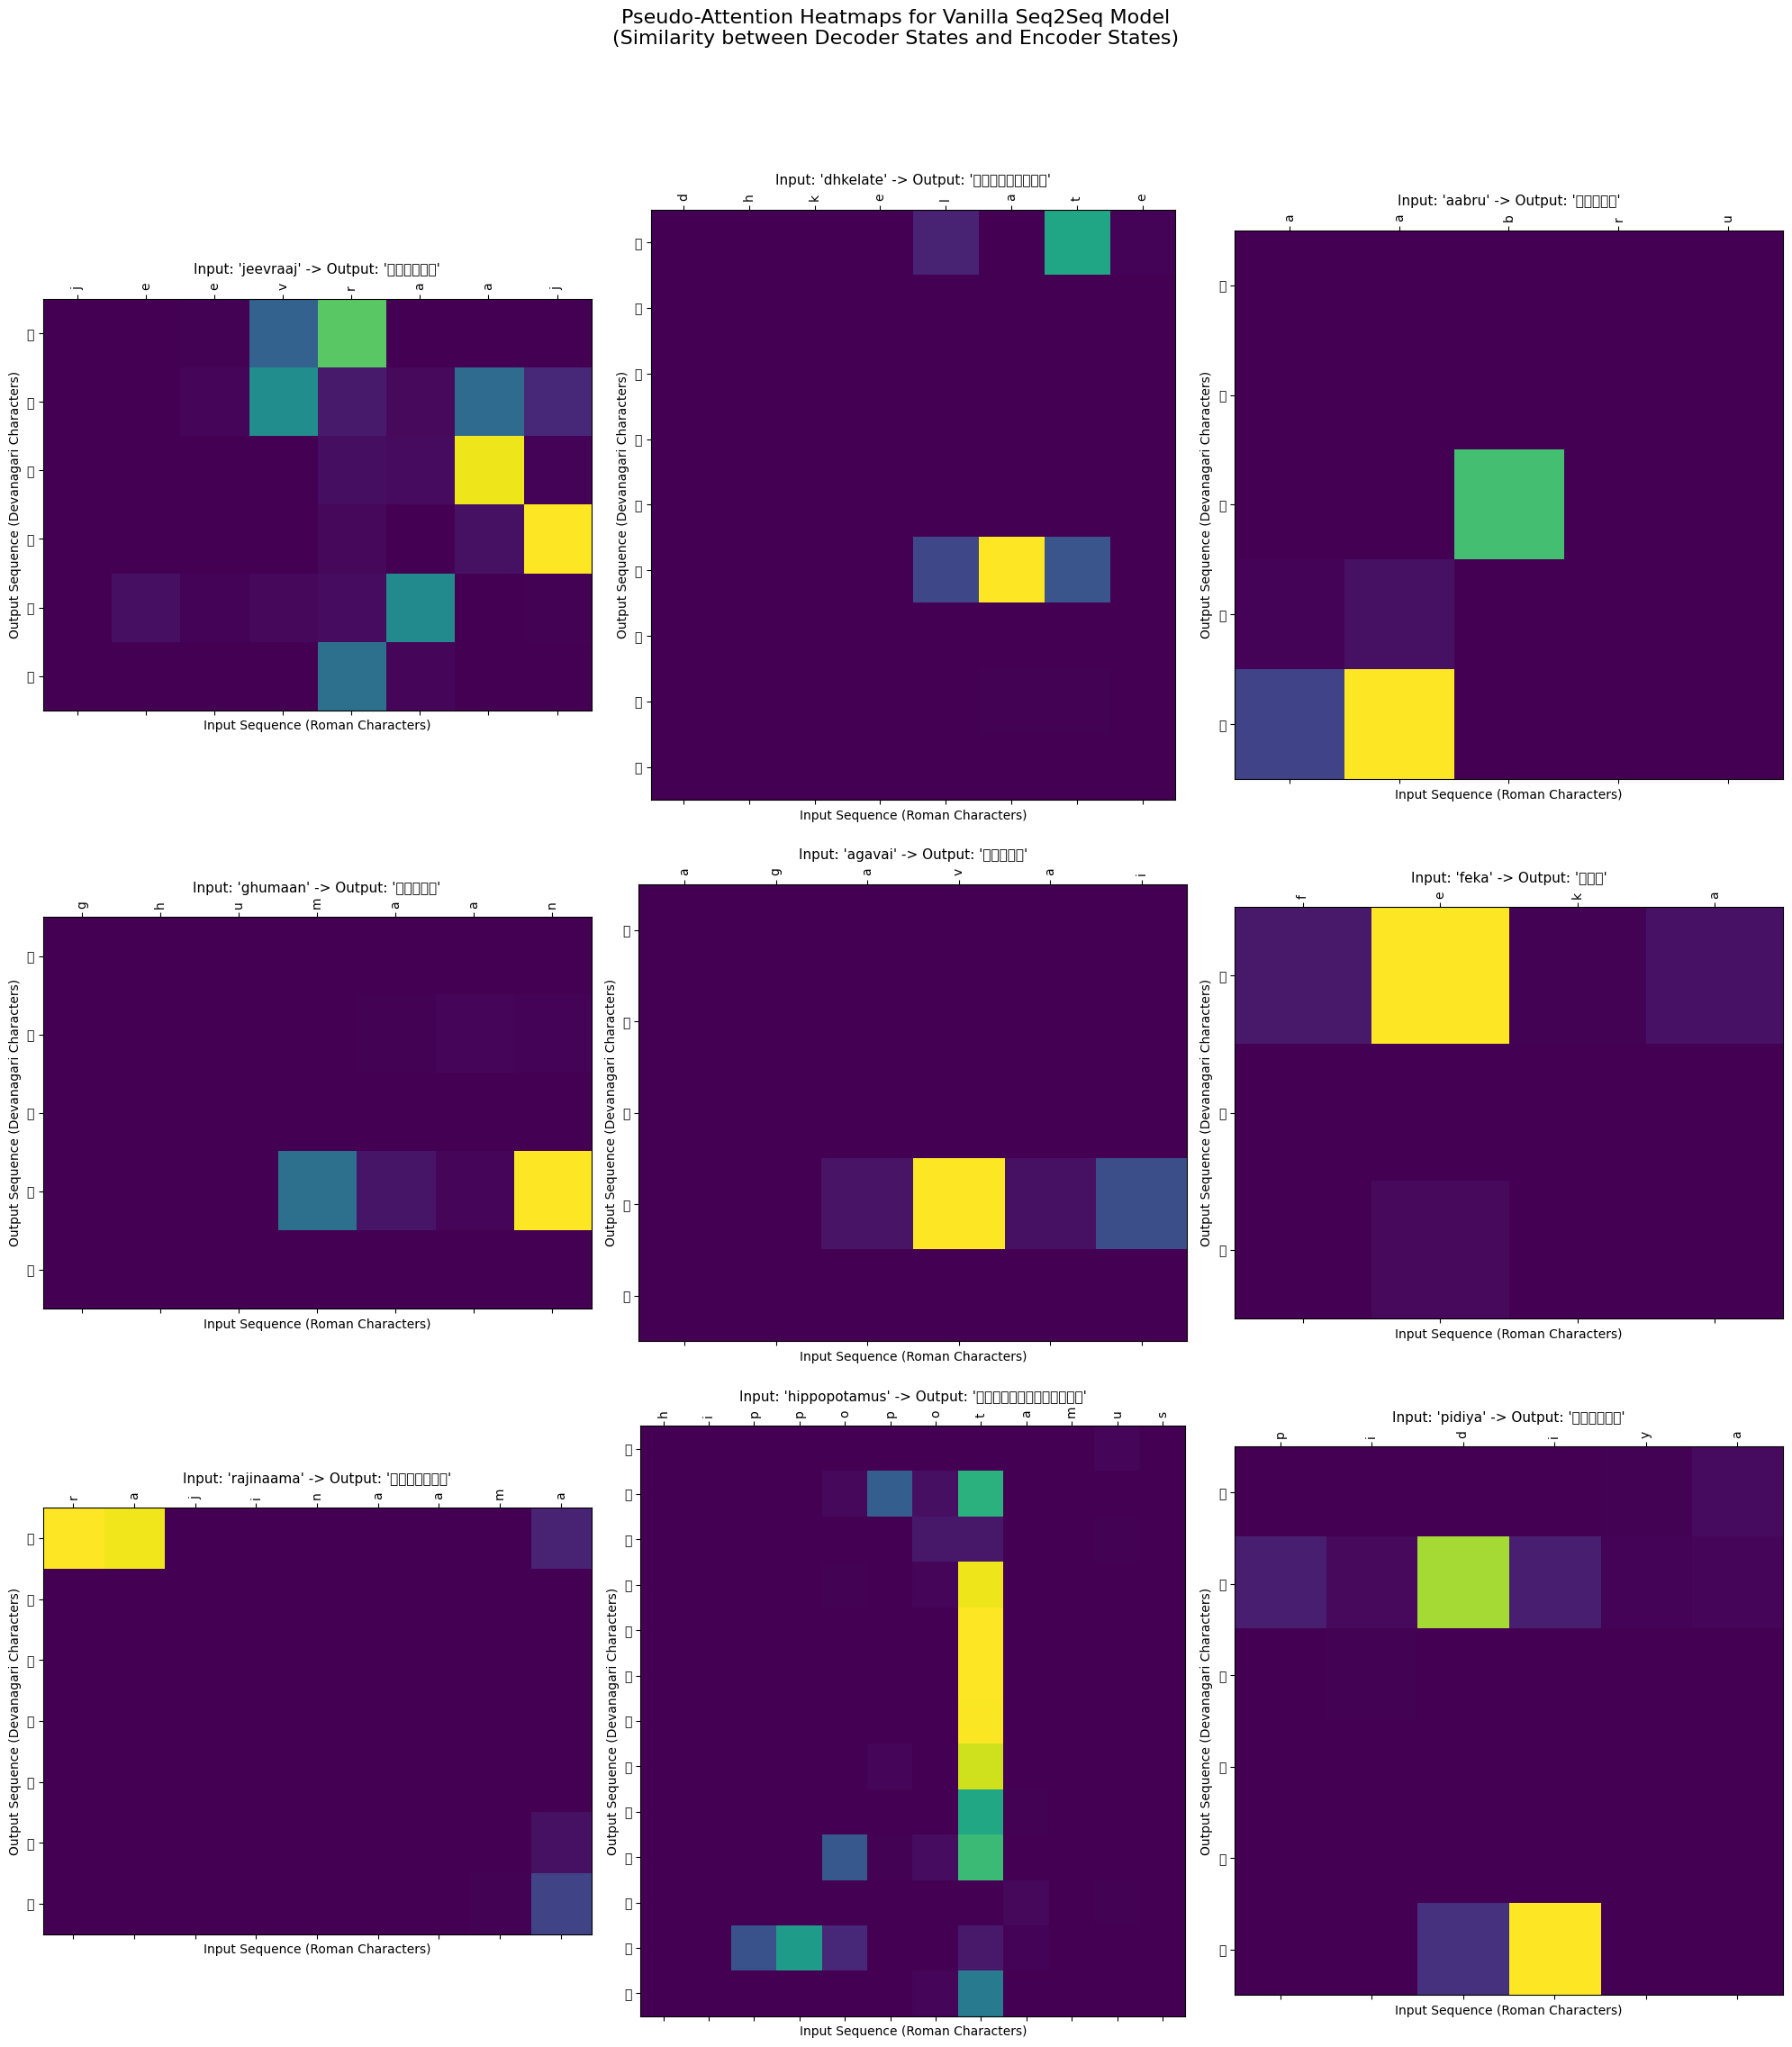

In [7]:
def plot_pseudo_attention_heatmap(input_text, output_text, attention_matrix, ax=None):
    """Plots the pseudo-attention heatmap."""
    if not input_text or attention_matrix.size == 0:
        # If no output_text is generated, we might still want to show input and empty output
        print(f"Cannot plot heatmap for input '{input_text}': Missing output or attention weights.")
        if ax is None:
            fig, ax_new = plt.subplots(figsize=(8, (1 + len(output_text) * 0.3) if output_text else 3))
            ax = ax_new
        ax.text(0.5, 0.5, "Data Unavailable or Empty Output", ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Input: {input_text[:30]}{'...' if len(input_text)>30 else ''}")
        if ax is None: plt.show() # show if not part of subplot
        return

    input_tokens = list(str(input_text))
    # Output text might be empty if decoding failed or EOS was first.
    output_tokens = list(str(output_text)) if output_text else ["<EOS_early>"] 

    max_len_plot = 25 
    plot_input_tokens = input_tokens[:max_len_plot]
    plot_output_tokens = output_tokens[:max_len_plot]
    if not plot_output_tokens or not plot_input_tokens or attention_matrix.shape[0] == 0 or attention_matrix.shape[1] == 0:
         plot_attention = np.zeros((max(1,len(plot_output_tokens)), len(plot_input_tokens))) # Default to zeros
    else:
        plot_attention = attention_matrix[:len(plot_output_tokens), :len(plot_input_tokens)]

    if ax is None: # Create a new figure and axis if not provided (for single plot)
        fig, ax_new = plt.subplots(figsize=(max(6,len(plot_input_tokens)*0.6), max(5,len(plot_output_tokens)*0.5)))
        ax = ax_new
    
    cax = ax.matshow(plot_attention, cmap='viridis') # 'bone', 'viridis', 'plasma'

    ax.set_xticklabels([''] + plot_input_tokens, rotation=90, fontsize=10)
    ax.set_yticklabels([''] + plot_output_tokens, fontsize=10)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    # Shorten title if input_text is too long
    display_input_text = (input_text[:25] + '...') if len(input_text) > 25 else input_text
    ax.set_title(f"Input: '{display_input_text}' -> Output: '{output_text}'", fontsize=11, pad=20)
    ax.set_xlabel("Input Sequence (Roman Characters)", fontsize=10)
    ax.set_ylabel("Output Sequence (Devanagari Characters)", fontsize=10)
    
    # Add colorbar to the figure if we created it here
    if 'fig' in locals() and fig: # If fig was created in this function call
         fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)


# --- Select some test samples and visualize ---
num_samples_to_visualize = 9 # For a 3x3 grid

# Ensure test data is vectorized for encoder input
encoder_input_test_viz, _, _ = vectorize_data(input_texts_test, [""]*len(input_texts_test)) # Dummy targets

# Create a 3x3 grid for heatmaps
fig_grid, axes_grid = plt.subplots(3, 3, figsize=(20, 22)) # Adjust figsize as needed
axes_grid = axes_grid.flatten() # Flatten to 1D array for easy iteration

sample_indices_viz = np.random.choice(len(input_texts_test), num_samples_to_visualize, replace=False)

plot_count = 0
for i, sample_idx in enumerate(sample_indices_viz):
    if plot_count >= len(axes_grid): break

    input_text_sample = input_texts_test[sample_idx]
    
    input_seq_vec_sample = encoder_input_test_viz[sample_idx:sample_idx+1]
    
    print(f"\nProcessing sample {i+1}/{num_samples_to_visualize}: '{input_text_sample}'")
    
    decoded_sentence_viz, pseudo_attention_matrix_viz, _, _ = decode_and_compute_pseudo_attention(
        input_seq_vec_sample, encoder_model_viz, decoder_model_viz, best_vanilla_config
    )
    
    print(f"  Input: {input_text_sample}")
    print(f"  Predicted Output: {decoded_sentence_viz}")
    if pseudo_attention_matrix_viz.size > 0:
        print(f"  Pseudo-Attention Matrix Shape: {pseudo_attention_matrix_viz.shape}")
    else:
        print("  Pseudo-Attention Matrix is empty.")

    plot_pseudo_attention_heatmap(input_text_sample, decoded_sentence_viz, pseudo_attention_matrix_viz, ax=axes_grid[plot_count])
    plot_count += 1

# Hide any unused subplots if num_samples_to_visualize < 9
for j in range(plot_count, len(axes_grid)):
    fig_grid.delaxes(axes_grid[j])

fig_grid.suptitle("Pseudo-Attention Heatmaps for Vanilla Seq2Seq Model\n(Similarity between Decoder States and Encoder States)", fontsize=16, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
plt.savefig("Q6.png")
plt.show()